## Preprocessing

In [1]:
import netCDF4 as nc  
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from global_land_mask import globe
from aux_ncdf import preprocess_data, add_max_increasing_chain, add_max_high_temp_chain, add_large_jump, calculate_increasing_temp_features, calculate_high_temp_features, calculate_temp_jump_features


In [2]:
file_name_temp = 'data/tasmax_CanESM5_historical_Arg.nc'
file_name_pp = 'data/pr_CanESM5_historical_Arg.nc'
results_folder = 'results'

dset_temp = xr.open_dataset(f'./{file_name_temp}')
dset_pp = xr.open_dataset(f'./{file_name_pp}')

df_temp = dset_temp.to_dataframe().reset_index()
df_pp = dset_pp.to_dataframe().reset_index()

seconds_per_day = 86400
df_raw = pd.merge(df_temp, df_pp, on=['lat', 'lon', 'time'])

df_raw['lon'] = df_raw['lon'] - 360

df_raw['t2m'] = df_raw['tasmax'] - 273.15
df_raw['tp'] = df_raw['pr']*seconds_per_day

df_raw['time'] = pd.to_datetime(df_raw.time.astype(str))

df_raw['year'] = df_raw.time.dt.year
df_raw['month'] = df_raw.time.dt.month
df_raw['day'] = df_raw.time.dt.day
df_raw['hour'] = df_raw.time.dt.hour

df_raw['station'] = df_raw['lat'].astype(str)+'_'+df_raw['lon'].astype(str)

df = df_raw[['year', 'month', 'day', 'station', 't2m', 'tp', 'lat', 'lon']].rename(columns={'lat': 'latitude', 
                                                                                            'lon':'longitude',
                                                                                            't2m': 'TMAX',
                                                                                            'tp': 'PP'})

In [65]:
for season in ['winter', 'summer']:
    for pp_lower_bound in [1]: # [1, 5]
        for grouping_strategy in [0, 1, 2, 3]:            
            print(f'Season: {season}')
            print(f'PP lower bound: {pp_lower_bound}')
            print(f'Grouping strategy: {grouping_strategy}')

            extreme_value_strategy = 'local'

            df_prep = preprocess_data(df, season=season, pp_lower_bound=pp_lower_bound, grouping_strategy=grouping_strategy, extreme_value_strategy=extreme_value_strategy)
            df_prep = add_max_increasing_chain(df_prep, eps=0.5)
            df_prep = add_max_high_temp_chain(df_prep, perc=0.75)
            df_prep = add_large_jump(df_prep, perc=0.9, rain_delay=1)
            extreme_pp_rate = df_prep.groupby('station').PP_extreme.agg(['mean', 'count']).reset_index()
            extreme_pp_rate.columns = ['station', 'extreme_pp_rate', 'days_with_pp']
            
            extreme_pp_value = df_prep[df_prep.PP_extreme == 1].groupby('station').PP.min().reset_index().rename(columns={'PP': 'extreme_pp_value'})
            extreme_pp_rate = pd.merge(extreme_pp_rate, extreme_pp_value, on='station', how='left')
            
            increasing_chain_freqs, increasing_chain_pp_extreme, increasing_avg_chain_length, increasing_avg_chain_length_for_extremes, increasing_optimal_length = calculate_increasing_temp_features(df_prep)
            high_t_chain_freqs, high_t_chain_pp_extreme, high_t_avg_chain_length, high_t_avg_chain_length_for_extremes, high_t_optimal_length = calculate_high_temp_features(df_prep) 
            freq_large_jump_pos, pp_extreme_large_jump_pos, freq_large_jump_neg, pp_extreme_large_jump_neg = calculate_temp_jump_features(df_prep)
            
            increasing_optimal_length = increasing_optimal_length.rename(columns={'optimal_length': 'increasing_optimal_length', 
                                                                                 'optimal_length_pp_extreme': 'increasing_optimal_length_pp_extreme'})
            
            high_t_optimal_length = high_t_optimal_length.rename(columns={'optimal_length': 'high_t_optimal_length', 
                                                                          'optimal_length_pp_extreme': 'high_t_optimal_length_pp_extreme'})
            
            pp_extreme_large_jump_pos = pp_extreme_large_jump_pos.rename(columns = {'PP_extreme': 'large_jump_pos_extreme_pp_rate'})
            pp_extreme_large_jump_neg = pp_extreme_large_jump_neg.rename(columns = {'PP_extreme': 'large_jump_neg_extreme_pp_rate'})
            
            results = pd.merge(increasing_avg_chain_length, increasing_avg_chain_length_for_extremes, on='station', how='left')
            results = pd.merge(results, increasing_optimal_length, on='station')
            results = pd.merge(results, high_t_avg_chain_length, on='station')
            results = pd.merge(results, high_t_avg_chain_length_for_extremes, on='station', how='left')
            results = pd.merge(results, high_t_optimal_length, on='station')
            results = pd.merge(results, freq_large_jump_pos, on='station')
            results = pd.merge(results, pp_extreme_large_jump_pos, on='station', how='left')
            results = pd.merge(results, freq_large_jump_neg, on='station')
            results = pd.merge(results, pp_extreme_large_jump_neg, on='station', how='left')
            results = pd.merge(results, extreme_pp_rate, on='station')
            
            results['lat'] = results.station.apply(lambda x: float(x.split('_')[0]))
            results['lon'] = results.station.apply(lambda x: float(x.split('_')[1]))
            results['is_land'] = results[['lat', 'lon']].apply(lambda r: globe.is_land(lat=r['lat'], lon=r['lon']), axis=1)
            
            extreme_pp_metrics = ['increasing_optimal_length_pp_extreme',
                                  'high_t_optimal_length_pp_extreme',
                                  'large_jump_pos_extreme_pp_rate',
                                  'large_jump_neg_extreme_pp_rate']
            
            for metric in extreme_pp_metrics:
                results[f'{metric}_norm'] = results[metric]/results.extreme_pp_rate

            results['avg_high_t_chain_length_for_extremes_norm'] = results['avg_high_t_chain_length_for_extremes']/results['avg_high_t_chain_length']
            results['avg_increasing_chain_length_for_extremes_norm'] = results['avg_increasing_chain_length_for_extremes']/results['avg_increasing_chain_length']
            
            results.to_csv(f'results/map_{season}_pp_{pp_lower_bound}_strat_{grouping_strategy}_extremes_local.csv', index=False)
            print(results.station.nunique())
            print(' ')

Season: winter
PP lower bound: 1
Grouping strategy: 0
117
 
Season: winter
PP lower bound: 1
Grouping strategy: 1
117
 
Season: winter
PP lower bound: 1
Grouping strategy: 2
117
 
Season: winter
PP lower bound: 1
Grouping strategy: 3
117
 
Season: summer
PP lower bound: 1
Grouping strategy: 0
117
 
Season: summer
PP lower bound: 1
Grouping strategy: 1
117
 
Season: summer
PP lower bound: 1
Grouping strategy: 2
117
 
Season: summer
PP lower bound: 1
Grouping strategy: 3
117
 


## Visualization

In [66]:
import pandas as pd
import plotly.express as px

titles_map = {
    'avg_increasing_chain_length': 'Average increasing temperature chain before rain', 
    'avg_increasing_chain_length_for_extremes': 'Average increasing temperature chain before extreme rain', 
    'avg_increasing_chain_length_for_extremes_norm': 'Average increasing temperature chain before extreme rain divided by average increasing temperature chain before rain', 
    'increasing_optimal_length': 'Optimal increasing temperature chain length',
    'increasing_optimal_length_pp_extreme': 'Extreme PP rate for optimal increasing temperature chain length',
    'increasing_optimal_length_pp_extreme_norm': 'Normalized extreme PP rate for optimal increasing temperature chain length', 
    'avg_high_t_chain_length': 'Average high temperature chain before rain',
    'avg_high_t_chain_length_for_extremes': 'Average high temperature chain before extreme rain',
    'avg_high_t_chain_length_for_extremes': 'Average high temperature chain before extreme rain divided by average high temperature chain before rain',
    'high_t_optimal_length': 'Optimal high temperature chain length',
    'high_t_optimal_length_pp_extreme': 'Extreme PP rate for optimal high temperature chain length',
    'high_t_optimal_length_pp_extreme_norm': 'Normalized extreme PP rate for optimal high temperature chain length',
    'large_jump_pos': 'Rate of large positive temperature jumps', 
    'large_jump_pos_extreme_pp_rate': 'Extreme PP rate for large positive temperature jumps',
    'large_jump_pos_extreme_pp_rate_norm': 'Normalized extreme PP rate for large positive temperature jumps', 
    'large_jump_neg': 'Rate of large negative temperature jumps', 
    'large_jump_neg_extreme_pp_rate': 'Extreme PP rate for large negative temperature jumps',
    'large_jump_neg_extreme_pp_rate_norm': 'Normalized extreme PP rate for large negative temperature jumps',
    'extreme_pp_rate': 'Extreme PP rate',
    'extreme_pp_value': 'Minimum extreme PP value',
    'days_with_pp': 'Number of days with PP'
}

def run_map(results, metric, size=1, zoom=2, color_scale=px.colors.sequential.RdBu_r, width=800, height=400, opacity=0.5, range_color=(0, 2), land_only=True):
    if land_only:
        map_data = results[results.is_land]
    else:
        map_data = results
    map_data['size'] = size
    
    fig = px.scatter_mapbox(map_data, 
                            lat="lat", 
                            lon="lon",
                            color=metric,
                            size='size',
                            size_max=size,
                            zoom=zoom,
                            color_continuous_scale=color_scale,
                            width=width, 
                            height=height,
                            title=titles_map[metric],
                            opacity=opacity,
                            range_color=range_color)
    
    fig.update_layout(mapbox_style="open-street-map")
    
    return fig

In [71]:
season = 'winter'
pp_lower_bound = 1
grouping_strategy = 3

viz_results_folder = 'results_new_model'

results = pd.read_csv(f'./{viz_results_folder}/map_{season}_pp_{pp_lower_bound}_strat_{grouping_strategy}_extremes_local.csv')

In [72]:
metric = 'extreme_pp_value'

print(results[metric].agg(['min', 'max']))
print(' ')
print(results[metric].quantile([0.02, 0.05, 0.95, 0.98]))

min     2.827955
max    38.492019
Name: extreme_pp_value, dtype: float64
 
0.02     8.779730
0.05    10.910176
0.95    35.615882
0.98    37.198960
Name: extreme_pp_value, dtype: float64


/var/folders/ts/hwmkfvzd43dd8kdtjgjcwgwc0000gp/T/ipykernel_74760/4278319655.py:33: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



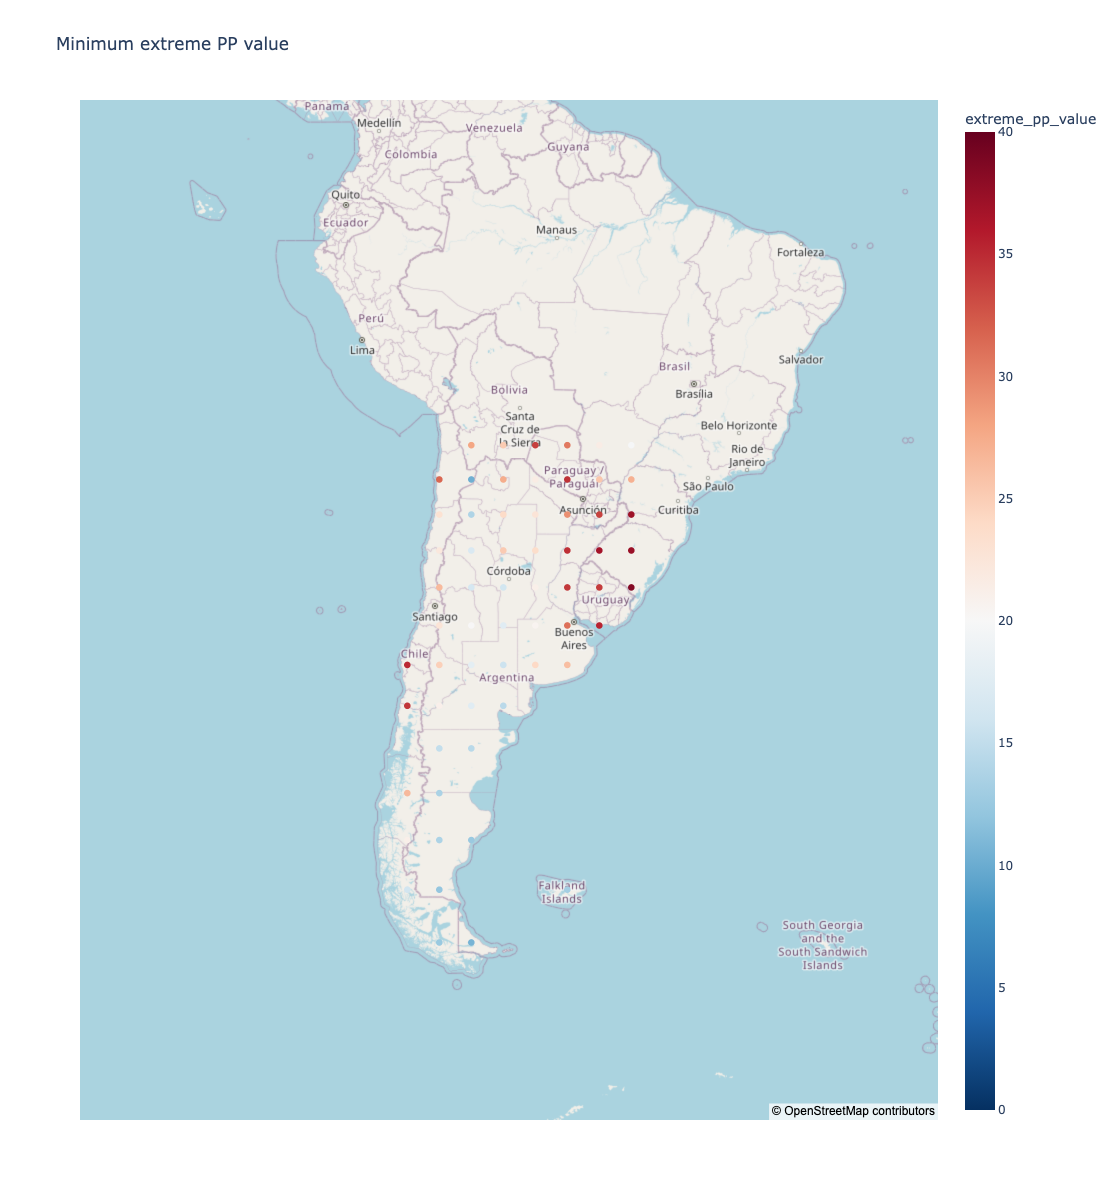

In [73]:
fig = run_map(results=results[~results[metric].isnull()], 
              metric=metric, # -> pones la metrica (de la lista de arriba)
              size=5, 
              zoom=3, 
              color_scale= px.colors.sequential.RdBu_r,
              width=1200,
              height=1200,
              opacity=1,
              range_color=(0, 40)) # -> elegis el rango de color, podes mirar en la data el minimo y el maximo

fig.show()